In [1]:
!pip install -r requirements.txt --quiet

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      running bdist_wheel
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-qf78ov_b/sklearn_4b59992673164332b19bd7ee80142307/setup.py", line 121, in <module>
          setuptools.setup(
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/__init__.py", line 155, in setup
          return distutils.core.setup(**attrs)
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 148, in setup
          return run_commands(dist)
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/setuptools/_distutils/core.py", line 163, in run_commands
          dist.run_commands()
        File "/opt/saturncloud/envs/saturn/lib/python3.9/site-p

In [2]:
import cudf
import cuml
import numpy as np
import scanpy as sc
import muon as mu
import pandas as pd
import gc
from numba import cuda
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/cupy/_environment.py:437: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda115

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.4.4 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [3]:
adata = sc.read_h5ad('./sc_training.h5ad')
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

In [4]:
valid_genes = [ 'Aqr', 'Bach2', 'Bhlhe40']
test_genes = [ 'Ets1', 'Fosb', 'Mafk', 'Stat3']

In [5]:
def proportions(data, ko_gene, return_n = False):
    ordering = ['progenitor','effector','terminal exhausted','cycling','other']
    counts = np.zeros(5)
    data_subset = data[data['condition'] == ko_gene]
    for i,state in enumerate(ordering):
        counts[i] = (data_subset['state'] == state).sum()
    n = len(data_subset)
    if return_n:
        return counts / n, n
    else:
        return counts / n
    

In [5]:
all_props = np.zeros((67,5))

In [6]:
genes = adata.obs['condition'].unique().tolist()
for i,g in enumerate(genes):
    all_props[i] = proportions(adata.obs,g)

In [7]:
df = pd.DataFrame(data=all_props, index=genes)

# UMAP Setup

In [6]:
from cuml import UMAP, PCA, HDBSCAN, KMeans, DBSCAN
import torch
import cupy as cp
from sklearn.model_selection import train_test_split
from scipy.stats import mode as scimode

In [7]:
cudata = cudf.DataFrame(adata.to_df())

In [8]:
colors = ['blue','red','green','yellow','pink']
ordering = ['progenitor','effector','terminal exhausted','cycling','other']
classes = [0,1,2,3,4]

colordict = {s:c for (s,c) in zip(ordering, colors)}
classdict = {s:c for (s,c) in zip(ordering, classes)}

genecolors = [colordict[s] for s in adata.obs['state']]
classes = [classdict[s] for s in adata.obs['state']]

### Helper Functions

In [17]:
def catgy_cluster_map(from_coords, from_cat, to_coords, to_cat):
    # So that we can define a mapping
    assert(len(np.unique(from_cat)) >= len(np.unique(to_cat)))
    
    dists = c1toc2(from_coords, from_cat, to_coords, to_cat)
    dists = sorted(dists, key=lambda x: x[0][0])
    
    mapper = {c1:c2 for (c1,c2),d in dists}
    return mapper

In [18]:
def get_centroid(posns):
    return np.sum(posns, axis=0)/len(posns)

In [19]:
def c1toc2(coords1, clust1, coords2, clust2):
    """
    coords1: nx2-dim numpy array of coordinates in embedded cluster
    clust1: n-dim numpy array of clusters
    
    coords2: mx2-dim numpy array of coordinates in embedded cluster
    clust2: m-dim numpy array of clusters
    """
    cents1 = {}
    for c in np.unique(clust1):
        c_coords = coords1[clust1 == c]
        cents1[c] = get_centroid(c_coords)
        
    cents2 = {}
    for c in np.unique(clust2):
        c_coords = coords2[clust2 == c]
        cents2[c] = get_centroid(c_coords)
    pairs = []
    for c1 in cents1:
        mindist = 10000
        pair = (0,0)
        for c2 in cents2:
            dist = np.sum(np.square(cents1[c1] - cents2[c2]))
            if dist < mindist:
                mindist = dist
                pair = (c1,c2)
        pairs.append((pair,mindist))
    return pairs

In [20]:
from scipy.stats import mode

def cluster_match(adata, classdict, cluster_filter):
    '''
    cluster_filter: array of true/false that indicates which rows of adata we are concerned with
    
    returns: adata class given by classdict mapping
    '''
    cluster_data = [classdict[c] for c in adata.obs['state'][cluster_filter]]
    cluster_mode = mode(cluster_data).mode[0]
    return cluster_mode

In [65]:
# from scipy.stats import mode

# def cluster_mapper_same_space(coords1, clust1, coords2, clust2):
#     cents1 = {}
#     for c in np.unique(clust1):
#         c_coords = coords1[clust1 == c]
#         cents1[c] = get_centroid(c_coords)
        
#     pairs = []
#     sample_len = 5
#     for c1 in cents1:
#         distpairs = np.sum(np.square(coords2 - c1), axis=1)
#         pairsorted = np.sort(distpairs)
        
#         # assert len(pairsorted) >= sample_len
#         # distmax = np.max(pairsorted[:sample_len])
#         # distmean = np.sum(pairsorted[:sample_len])/sample_len
#         # clust_cats = clust2[np.where(distpairs <= m, True, False)]
#         # print('here')
#         # print(clust_cats)
#         # clustmode = mode(clust_cats).mode[0]
#         # pairs.append([(c1,clustmode),distmean])
#     print(len(pairs))
#     return pairs

In [22]:
def xentropy(p,q):
    return -np.sum(p*np.log(q))

In [23]:
def EMD(p, q):
    return np.abs(p-q).sum()

In [24]:
def proportions_clusters(data_subset, mapping, ordering=[0,1,2,3,4], return_n = False):
    counts = np.zeros(len(ordering))
    categories = data_subset.unique()
    for i,cat in enumerate(categories):
        counts[mapping[cat]] += (data_subset == cat).sum()
    n = len(data_subset)
    if return_n:
        return counts / n, n
    else:
        return counts / n

# Umap Fiddling

## PCA Transform

In [11]:
pca_comps = 200

pca_float = PCA(n_components = pca_comps)
pca_float.fit(cudata)
output = pca_float.transform(cudata)

## UMAP Fit and Transform 2d

In [ ]:
reducer = UMAP(n_neighbors=30,min_dist=0.3)
embedding = reducer.fit_transform(output)
embedding_big = reducer.fit_transform(cudata)

In [ ]:
embedding_big.shape

In [ ]:
plt.scatter(embedding_big[0].to_arrow().to_pylist(), embedding_big[1].to_arrow().to_pylist(), c=genecolors, s=10)
plt.title('UMAP embedding of genes');

In [ ]:
plt.scatter(embedding[0].to_arrow().to_pylist(), embedding[1].to_arrow().to_pylist(), c=genecolors, s=0.3)
plt.title('UMAP embedding of genes');

## UMAP Fit and Transform 3d

In [ ]:
reducer3d = UMAP(n_neighbors=30,min_dist=0.3, n_components=3)
gc.collect()

In [ ]:
embedding3d = reducer3d.fit_transform(output)

In [ ]:
embedding_big3d = reducer3d.fit_transform(cudata)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(embedding3d[0].to_arrow().to_pylist(), embedding3d[1].to_arrow().to_pylist(), embedding3d[2].to_arrow().to_pylist(), c=genecolors)
plt.title('UMAP embedding of genes');

# Experiment Time

### Set useful variables

In [77]:
colors = ['blue','red','green','black','pink']
ordering = ['progenitor','effector','terminal exhausted','cycling','other']
classes = [0,1,2,3,4]

colordict = {s:c for (s,c) in zip(ordering, colors)}
classdict = {s:c for (s,c) in zip(ordering, classes)}

genecolors = [colordict[s] for s in adata.obs['state']]
classes = [classdict[s] for s in adata.obs['state']]

### PCA

In [13]:
pca_comps = 100 # Number of components used in Innes's cell experiments

pca_train = PCA(n_components = pca_comps)
pca_train.fit(cudata)
output = pca_train.transform(cudata)

In [14]:
# We don't want to train on genes without perturbations

genes = adata.obs['condition'].unique().tolist()
genes.remove(genes[0])

### Data Splitting

In [16]:
train, test = train_test_split(genes,train_size = 0.75, random_state = 34)

In [17]:
train_set = set(train)
test_set = set(test)

In [18]:
train_ind = [x in train_set for x in adata.obs['condition']]
train_x = output[train_ind]
train_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][train_ind]])

In [19]:
test_ind = [x in test_set for x in adata.obs['condition']]
test_x = output[test_ind]
test_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][test_ind]])

In [20]:
cattest = [classdict[s] for s in adata.obs['state'][test_ind]]
colortest = [colordict[s] for s in adata.obs['state'][test_ind]]

colortrain = [colordict[s] for s in adata.obs['state'][train_ind]]
cattrain = np.array([classdict[s] for s in adata.obs['state'][train_ind]])

### Embed and Plot

In [46]:
reducer = UMAP(n_neighbors=30, min_dist=0.1)
reducer.fit(train_x,train_y, )

UMAP()

In [ ]:
y_train_est = reducer.transform(train_x)

In [ ]:
y_est = reducer.transform(test_x)

In [ ]:
plt.scatter(y_est[0].to_arrow().to_pylist(), y_est[1].to_arrow().to_pylist(), c=colortest, s=0.3)
plt.title('UMAP embedding of genes');

In [ ]:
plt.scatter(y_train_est[0].to_arrow().to_pylist(), y_train_est[1].to_arrow().to_pylist(), c=colortrain, s=0.3)
plt.title('UMAP embedding of genes');

# Map Clusters

### KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters = 6)
cats_kmeans = kmeans.fit_predict(y_est)

In [ ]:
plt.scatter(y_est[0].to_arrow().to_pylist(), 
            y_est[1].to_arrow().to_pylist(),
            c=kmeans.labels_.to_numpy(),
            s=0.13,
            cmap='Spectral');

### HDBSCAN Clusters of Test

In [ ]:
hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=100,)
cats_hdb = hdbscan.fit_predict(y_est)

In [ ]:
plt.scatter(y_est[0].to_arrow().to_pylist(), 
            y_est[1].to_arrow().to_pylist(),
            c=hdbscan.labels_.to_numpy(),
            s=0.13,
            cmap='Spectral');

### DBSCAN Clustering of Test

In [ ]:
dbscan = DBSCAN()
cats_db = dbscan.fit_predict(y_est)
clustered = [c >= 0 for c in cats_db.to_numpy()]
y_est_dn = y_est[clustered]
y_est_labels = dbscan.labels_[clustered].to_numpy()

In [ ]:
plt.scatter(y_est[0][clustered].to_arrow().to_pylist(), 
            y_est[1][clustered].to_arrow().to_pylist(),
            c=dbscan.labels_[clustered].to_numpy(),
            s=0.13,
            cmap='Spectral');

In [ ]:
plt.scatter(y_est[0][clustered].to_arrow().to_pylist(), 
            y_est[1][clustered].to_arrow().to_pylist(),
            c=pd.Series(cattest)[clustered].to_numpy(),
            s=0.13,
            cmap='Spectral');

### HDBScan clustering of train with threshold

In [ ]:
thresh = 0.5

hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=100,)

hdbscan.fit_predict(y_train_est)

clustered = [p > thresh for p in hdbscan.probabilities_.to_numpy()]

ytr_dn = y_train_est[clustered]
ytr_labels = hdbscan.labels_[clustered].to_numpy()

plt.scatter(ytr_dn[0].to_numpy(), 
            ytr_dn[1].to_numpy(),
            c=ytr_labels,
            s=0.13,
            cmap='Spectral');

n_clusters = np.unique(hdbscan.labels_[clustered].to_numpy())

### Compute clusters and distribution diff

In [ ]:
# est train to est test categories
dists = c1toc2(ytr_dn.to_numpy(),ytr_labels,y_est_dn.to_numpy(), y_est_labels)
dists = sorted(dists, key=lambda x: x[0][0])
# This is finnicky
#dists = list(filter(lambda d: d[1] < 2, dists))
c1_order = [d[0][0] for d in dists]
c2_order = [d[0][1] for d in dists]

#p1 = proportions_clusters(data_subset = ytr_labels, ordering = c1_order)
#p2 = proportions_clusters(data_subset = y_est_labels, ordering = c2_order)

In [ ]:
EMD(p1,p2), xentropy(p1,p2)

In [ ]:
dists = c1toc2(y_est_dn.to_numpy(), y_est_labels, y_est.to_numpy(), pd.Series(cattest))
dists = sorted(dists, key=lambda x: x[0][0])
# This is finnicky
#dists = list(filter(lambda d: d[1] < 2, dists))
c1_order = [d[0][0] for d in dists]
c2_order = [d[0][1] for d in dists]

#p1 = proportions_clusters(data_subset = y_est_labels, ordering = c1_order)
#p2 = proportions_clusters(data_subset = cattest, ordering = c2_order)

In [ ]:
mapper = catgy_cluster_map(y_est_dn.to_numpy(), y_est_labels, y_est.to_numpy(), pd.Series(cattest))

In [ ]:
y_est_mapped = pd.Series([mapper[x] for x in y_est_labels])
p1 = proportions_clusters(data_subset = y_est_mapped, ordering = [0,1,2,3,4])
p2 = proportions_clusters(data_subset = pd.Series(cattest), ordering = [0,1,2,3,4])

In [ ]:
EMD(p1,p2), xentropy(p1,p2)

# Run Experiment with Unperturbed and Simulated Perturbed gene

In [19]:
pca_comps = 100 # Number of components used in Innes's cell experiments

pca_train = PCA(n_components = pca_comps)
pca_train.fit(cudata)
output = pca_train.transform(cudata)

In [20]:
catunpt = [classdict[s] for s in adata.obs['state'][adata.obs['condition'] == 'Unperturbed']]

In [21]:
unpert_index = adata.obs['condition'] == 'Unperturbed'

In [22]:
genes_unpert = output[unpert_index]

In [23]:
train_ind = [x != 'Unperturbed' for x in adata.obs['condition']]
train_x = output[train_ind]
train_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][train_ind]])

In [24]:
test = adata.obs['state'].copy()

In [25]:
reducer = UMAP(n_neighbors=30, min_dist=0.1)
reducer.fit(train_x,train_y)

UMAP()

In [26]:
train_x_embed = reducer.transform(train_x)

In [27]:
unpert_y = reducer.transform(genes_unpert)

In [66]:
def get_orig_cluster(adata, classdict, subset, cluster):
    '''
    cluster selects the elements of the subset selected
    subset selects elements of adata
    '''
    indices_cluster = adata.obs['state'][subset].index[cluster]
    states_cluster = adata.obs['state'][indices_cluster]
    classes_cluster = [classdict[s] for s in states_cluster]
    mode = scimode(classes_cluster).mode[0]
    return mode

In [71]:
def get_cluster_mapping_to_orig(adata, classdict, subset, labels):
    """
    labels categorizes subset,
    subset selects part of adata
    
    range of mapping will always be {0,1,2,3,4}
    """
    mapping = {}
    categories = labels.unique()
    categories = categories[categories != -1]
    for c in categories:
        cluster = [c == cat for cat in labels.to_numpy()]
        mapping[c] = get_orig_cluster(adata, classdict, subset, cluster)
    return mapping

In [134]:
mapping = get_cluster_mapping_to_orig(adata, classdict, subset, cats_dbscan.to_pandas())

proportions_clusters(data_subset = pd.Series(y_unpert_labels), mapping=mapping)


In [ ]:
thresh = 0.5

hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=100,)

hdbscan.fit_predict(train_x_embed)

clustered = [p > thresh for p in hdbscan.probabilities_.to_numpy()]

x_embed_test = y_train_est[clustered]
ytr_labels = hdbscan.labels_[clustered].to_numpy()

plt.scatter(ytr_dn[0].to_numpy(), 
            ytr_dn[1].to_numpy(),
            c=ytr_labels,
            s=0.13,
            cmap='Spectral');

In [135]:
dbscan = DBSCAN()
cats_dbscan = dbscan.fit_predict(y_unpert)
clustered = [c >= 0 for c in cats_dbscan.to_numpy()]
y_unpert_dn = y_unpert[clustered]
y_unpert_labels = dbscan.labels_[clustered].to_numpy()

In [ ]:
plt.scatter(y_unpert_dn[0].to_arrow().to_pylist(), 
            y_unpert_dn[1].to_arrow().to_pylist(),
            c=y_unpert_labels,
            s=0.13,
            cmap='Spectral');

In [30]:
pca_train = PCA(n_components = pca_comps)
pca_train.fit(cudata)


PCA()

In [35]:
adata_unpert

<0x15077 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

In [39]:
adata.X[adata.obs['state'] == 'Unperturbed']

<0x15077 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

# The Real Experiment

### PCA

In [27]:
pca_comps = 100
pca_train = PCA(n_components = pca_comps)
pca_train.fit(cudata)

PCA()

### Data Prep

In [36]:

gene_removed = test_genes[0]
unpert_ind = adata.obs['condition'] == 'Unperturbed'
adata_unpert = adata[unpert_ind]

ind = (adata.var_names == gene_removed).nonzero()[0]

adata_pert_copy = adata_unpert.to_df().to_numpy(copy=True)
adata_pert_copy[:,ind] = 0

In [38]:
pert_cudata = cudf.DataFrame(adata_pert_copy)

output = pca_train.transform(pert_cudata)

In [39]:
train_ind = [x != 'Unperturbed' for x in adata.obs['condition']]
# Project train data into lower dimension
train_x = pca_train.transform(cudata[train_ind])
# Known labels for train data
train_y = cudf.DataFrame([classdict[s] for s in adata.obs['state'][train_ind]])

### UMAP Fit, Embed

In [39]:
reducer = UMAP(n_neighbors=30, min_dist=0.1)
reducer.fit(train_x,train_y)

UMAP()

In [40]:
p_embed = reducer.transform(output)

In [41]:
t_embed = reducer.transform(train_x)

### HDBScan Clusters

In [42]:
# hdbscan_train = HDBSCAN()
# train_cats_dbscan = hdbscan_train.fit(t_embed, )
# train_clustered = [c >= 0 for c in cats_dbscan.to_numpy()]
# t_embed_dn = t_embed[clustered]
# t_embed_labels = dbscan.labels_[clustered].to_numpy()

In [73]:
sum(train_ind)

23719

In [75]:
t_ind = np.where(t_labels > 0, True, False)

In [78]:
len(t_ind)

20467

In [77]:
sum(t_ind)

18783

In [82]:
len(hdbscan_t.labels_)

23719

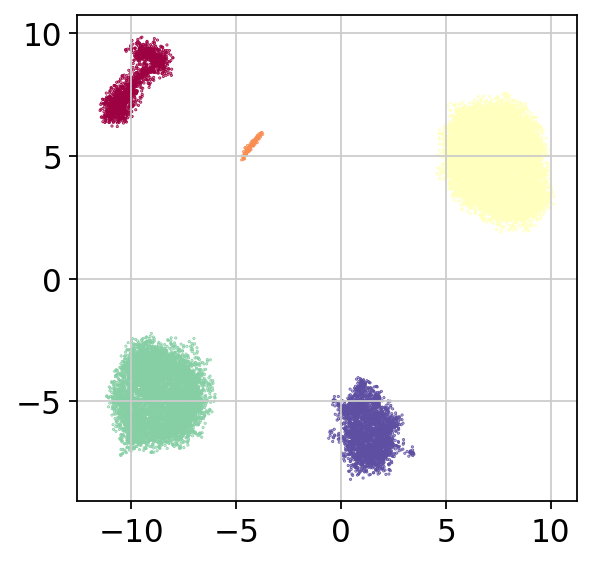

In [84]:
thresh = 0.3

hdbscan_t = HDBSCAN(min_samples=10,
    min_cluster_size=100,)

clusters_t = hdbscan_t.fit_predict(t_embed)

clustered = [p > thresh for p in hdbscan_t.probabilities_.to_numpy()]

t_dn = t_embed[clustered]
t_labels = hdbscan_t.labels_[clustered].to_numpy()

plt.scatter(t_dn.to_numpy()[:,0], 
            t_dn.to_numpy()[:,1],
            c=t_labels,
            s=0.13,
            cmap='Spectral');

# Set deleted labels to -1
t_proba = hdbscan_t.probabilities_.to_numpy()
t_deleted = np.where(t_proba <= thresh, True , False)
t_labels_padded = hdbscan_t.labels_.copy()
t_labels_padded[t_deleted] = -1

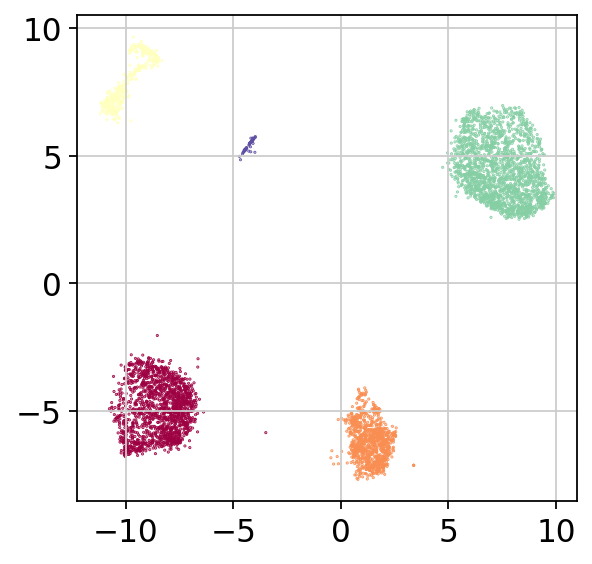

In [56]:
thresh = 0.0

hdbscan = HDBSCAN(min_samples=10,
    min_cluster_size=10,)

clusters_p = hdbscan.fit_predict(p_embed)

clustered = [p > thresh for p in hdbscan.probabilities_.to_numpy()]

p_dn = p_embed[clustered]
p_labels = hdbscan.labels_[clustered].to_numpy()

plt.scatter(p_dn.to_numpy()[:,0], 
            p_dn.to_numpy()[:,1],
            c=p_labels,
            s=0.13,
            cmap='Spectral');

### Class Conversion

In [57]:
# p -> t

# est train to est test categories
dists = c1toc2(p_dn.to_numpy(),p_labels,t_dn.to_numpy(), t_labels)
dists = sorted(dists, key=lambda x: x[0][0])

In [58]:
dists

[((0, 3), 0.08419599),
 ((1, 4), 0.002245527),
 ((2, 0), 0.004852621),
 ((3, 2), 0.111683555),
 ((4, 1), 0.0005610796)]

In [88]:
p_to_t_map = catgy_cluster_map(p_dn.to_numpy(),p_labels,t_dn.to_numpy(), t_labels)

t_to_orig_map = get_cluster_mapping_to_orig(adata, classdict, train_ind, t_labels_padded.to_pandas())

In [89]:
t_to_orig_map

{4: 1, 2: 3, 0: 0, 3: 2, 1: 4}

In [ ]:

# This is finnicky
#dists = list(filter(lambda d: d[1] < 2, dists))
c1_order = [d[0][0] for d in dists]
c2_order = [d[0][1] for d in dists]

#p1 = proportions_clusters(data_subset = ytr_labels, ordering = c1_order)
#p2 = proportions_clusters(data_subset = y_est_labels, ordering = c2_order)

In [ ]:
mapping = get_cluster_mapping_to_orig(adata, classdict, , cats_dbscan.to_pandas())

proportions_clusters(data_subset = pd.Series(y_unpert_labels), mapping=mapping)